# Sujet 4 : Estimation de la latence et de la capacité d’une connexion à partir de mesures asymétriques

On commence par déclarer les bibliothèques utilisés :

Note : `urllib.request` n'y est pas car elle n'est utilisée que dans le cas où on doit télécharger les données.

In [1]:
%matplotlib inline
import re
import gzip
import time
import pandas
import io
import os
import datetime

## Connexion courte à l'intérieur d'un campus

On commence par récupérer les données à étudier :

In [2]:
def telecharger_fichier_si_necessaire(data_url):

    # Extrait le nom du fichier à partir de l'URL
    data_file = data_url[(data_url.rindex("/")+1):]

    # Vérification de l'extention
    if data_file[-7:] != ".log.gz":
        raise Exception("Le fichier nom de fichier "+data_file+" ne finit pas par \".log.gz\" !")

    if not os.access(data_file, os.R_OK):
        import urllib.request
        print("Les données n'existent pas en local, on les télécharges.")
        urllib.request.urlretrieve(data_url, data_file)
        if os.access(data_file, os.R_OK):
            print("Fichier récupéré.")
        else:
            raise Exception("Le fichier n'a pas pu être récupéré !")
    else:
        print("Les données sont déjà présentes en local.")

telecharger_fichier_si_necessaire("http://mescal.imag.fr/membres/arnaud.legrand/teaching/2014/RICM4_EP_ping/liglab2.log.gz")

Les données sont déjà présentes en local.


On définit la fonction qui va lire chaque ligne pour en extraire les données. La ligne retournée sera formatée en CSV.

Comme ce qui nous intéresse est le temps mis pour latence (ou "ping") il faut impérativement que celle ci soit présente pour que la ligne soit reconnue, pour les lignes dans ce cas on retournera `Ǹone`.

Si la ligne est totalement illisible on soulèvera une exception afin d'avertir l'utilisateur qu'il y a des lignes dont le format est illisible par le programme. Ceci est préférable au fait de retourner `Ǹone` car si c'était le cas on risquerait de masquer des données utiles, par exemple si `ping` avait retourné des données en secondes plutôt qu'en millisecondes.

In [3]:
extractDataFromLineRegExp = re.compile("^\[([0-9\.]+)\] ([0-9]+) bytes[^:]*: icmp_seq=[0-9]+ ttl=[0-9]+( time=([0-9\.]+) ms)?$")
def extractDataFromLine(line):
    match = extractDataFromLineRegExp.match(line)
    if match and match[4]:
        return match[1]+","+match[2]+","+match[4]+"\n"
    elif match:
        return None
    else:
        raise Exception("La ligne \""+line+"\" n'est pas dans le format attendu.")

# Quelques essais
print(extractDataFromLine("[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 ms"))  # Le retour à la ligne est inclus dans ce qui est retourné
print(extractDataFromLine("[1421773281.582445] 13 bytes from stackoverflow.com (198.252.206.140): icmp_seq=1 ttl=50"))
print()
try:
    print(extractDataFromLine("[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 s"))
    print("On devrait avoir une exception ici.")
except Exception as e:
    print("Exception (attendue) : "+e.args[0])

1421761682.052172,665,22.5

None

Exception (attendue) : La ligne "[1421761682.052172] 665 bytes from lig-publig.imag.fr (129.88.11.7): icmp_seq=1 ttl=60 time=22.5 s" n'est pas dans le format attendu.


Lit les données du fichier, utilise la fonction `extractDataFromLine` définit précédemment pour extraire les données et les placer dans une variables `csv_data` qui contiendra les données au format CSV.

J'ai dans un premier temps essayé de ne pas passer par une variable intermédiaire et ajouter les données directement dans le DataFrame mais c'était extrêmement lent. Il aurait aussi été possible de passer par un fichier intermédiaire. En cas de données plus imposantes cela aurait été nécessaire.

In [4]:
def convertit_fichier_en_csv(data_file):
    nb = 0
    start_time = time.time()
    data = '"date","size","time"\n' # La première ligne du CSV à les noms de champs
    with gzip.open(data_file, 'rb') as file:
        for line in file:
            line_data = extractDataFromLine(line.decode('utf-8').strip())
            if line_data:
                data += line_data
            nb += 1

    print ("Lu %d lignes en %.3f sec" % (nb, time.time() - start_time))
    return data

csv_data = convertit_fichier_en_csv("liglab2.log.gz")

Lu 44413 lignes en 0.187 sec


Traduit le tableau du format CSV en temps que DataFrame pandas. Comme on lit depuis le contenu d'une variable on utilise `io.StringIO` qui permet de lire une variable comme on lit un fichier.

In [5]:
raw_data = pandas.read_csv(io.StringIO(csv_data))
# csv_data = None  # Libère la mémoire
raw_data

date  size   time
0      1.421762e+09   665  22.50
1      1.421762e+09  1373  21.20
2      1.421762e+09   262  21.20
3      1.421762e+09  1107  23.30
4      1.421762e+09  1128   1.41
5      1.421762e+09   489  21.90
6      1.421762e+09  1759  78.70
7      1.421762e+09  1146  25.10
8      1.421762e+09   884  24.00
9      1.421762e+09  1422  19.50
10     1.421762e+09  1180  18.00
11     1.421762e+09   999  18.80
12     1.421762e+09  1020  24.30
13     1.421762e+09    71   3.45
14     1.421762e+09    34   5.85
15     1.421762e+09  1843   2.31
16     1.421762e+09   407   1.14
17     1.421762e+09   356   1.10
18     1.421762e+09  1511   2.18
19     1.421762e+09   587   1.27
20     1.421762e+09   809   1.33
21     1.421762e+09  1364   1.51
22     1.421762e+09  1153   1.44
23     1.421762e+09   853   1.30
24     1.421762e+09  1510   2.17
25     1.421762e+09   123   1.21
26     1.421762e+09  1966   2.20
27     1.421762e+09   933   1.34
28     1.421762e+09   922   1.42
29     1.421762e+09    24   1.12
...             ...   ...    ...
44006  1.421771e+09  1772  28.80
44007  1.421771e+09    41   1.14
44008  1.421771e+09  1944   2.32
44009  1.421771e+09   400   1.98
44010  1.421771e+09   226   3.01
44011  1.421771e+09   466   7.45
44012  1.421771e+09   350  13.50
44013  1.421771e+09  1829  45.90
44014  1.421771e+09  1954  58.50
44015  1.421771e+09  1074   1.45
44016  1.421771e+09    46   1.11
44017  1.421771e+09  1844   2.26
44018  1.421771e+09   645   1.24
44019  1.421771e+09   444   1.25
44020  1.421771e+09  1940   2.46
44021  1.421771e+09  1411   1.47
44022  1.421771e+09    49   1.21
44023  1.421771e+09   420   1.55
44024  1.421771e+09   227   1.22
44025  1.421771e+09   947   1.34
44026  1.421771e+09  1960   2.43
44027  1.421771e+09   531   1.19
44028  1.421771e+09   374   1.14
44029  1.421771e+09  1503   2.19
44030  1.421771e+09   572   1.29
44031  1.421771e+09  1338   1.47
44032  1.421771e+09  1515   7.02
44033  1.421771e+09  1875   2.33
44034  1.421771e+09  1006   1.61
44035  1.421771e+09  1273   1.35

[44036 rows x 3 columns]

### Premiers constats sur les données

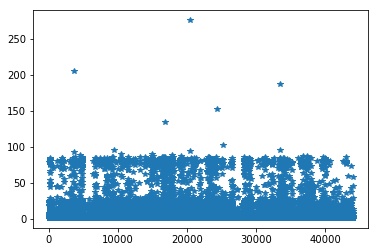

In [6]:
raw_data['time'].plot(style='*')

On remarque quelques points avec une latence nettement plus importante que d'habitude.

Sinon en histogramme (attention l'échelle est logarithmique) :

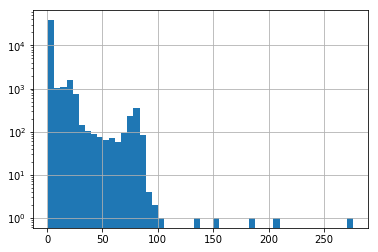

In [7]:
raw_data['time'].hist(log=True, bins=50)

On remarque bien que la majorité des requêtes ont une réponse quasi immédiate. Beaucoup ont une réponse dans les 30 ms. Les durées de 70-80 ms semble être surprenamment courantes. Il n'y a que très peu de réponses dont la durée est supérieure à 90ms.

### Y a t'il une variabilité par heure ou par jour de la semaine ?

Comme il s'agit d'un campus on peut s'attendre à une variabilité des performances due aux activités. On peut supposer que le réseau soit plus chargé durant les jours ouvrées et aux heures de travail.

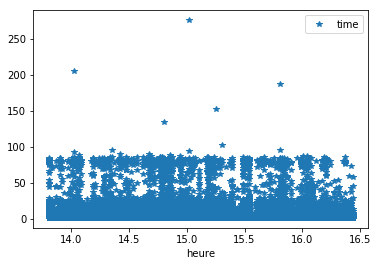

In [8]:
def timestamp_vers_heure(timestamp):
    str_time = datetime.datetime.fromtimestamp(timestamp).strftime('%H:%M:%S')
    parts = str_time.split(':')
    return float(parts[0]) + (float(parts[1]) / 60.0) + (float(parts[0]) / 3600.0)

raw_data['heure'] = [timestamp_vers_heure(ts) for ts in raw_data['date']]
raw_data.plot(x='heure', y='time', style='*')

Il semblerait que seuls quelques heures dans l'après midi soit présentes. Les données ont été prises juste sur quelques heures ou plusieurs jours aux mêmes heures ? Il aurait fallu vérifier la durée des l'observation.

In [9]:
print(datetime.datetime.fromtimestamp(raw_data['date'].min()).strftime('%d/%m/%Y %H:%M:%S'))
print(datetime.datetime.fromtimestamp(raw_data['date'].max()).strftime('%d/%m/%Y %H:%M:%S'))

20/01/2015 13:48:02
20/01/2015 16:26:26


Les données ne sont présente que pour une petite tranche horaire durant une seule journée. Il s'agit d'un mardi donc jour ouvré mais je ne penses pas que l'on puisse faire des statistiques liés à la variation de charge réseau. Les données ne montrent pas de fortes variations qui pourrait être expliqué par un usage très différent du réseau à un moment donné.

### Temps de transmission en fonction de la taille des messages.
